In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile as zf
import imutils
import cv2
import dlib
import random
import tensorflow as tf

from keras.layers import Dense,Conv2D,MaxPool2D,AveragePooling2D,Flatten,Dropout,Activation
from keras.models import Sequential
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.utils import np_utils
from keras.preprocessing.image import img_to_array

from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer,LabelEncoder

from imutils import build_montages
from google.colab.patches import cv2_imshow

sns.set()

In [0]:
filepath_prototxt = '/content/deploy.prototxt.txt'
filepath_model = '/content/res10_300x300_ssd_iter_140000.caffemodel'

In [570]:
os.getcwd()

'/content'

In [0]:
handle_train=zf.ZipFile(r'/content/train.zip')
handle_train.extractall('/content/Training')
handle_train.close()

handle_test=zf.ZipFile(r'/content/test.zip')
handle_test.extractall('/content/Testing')
handle_test.close()

In [0]:
train_mask = os.listdir('/content/Training/train/train_with_mask/')
train_nomask = os.listdir('/content/Training/train/train_without_mask/')

test_mask = os.listdir('/content/Testing/test/test_with_mask/')
test_nomask = os.listdir('/content/Testing/test/test_without_mask/')


In [0]:
filepath_train_mask = '/content/Training/train/train_with_mask/'
filepath_train_nomask = '/content/Training/train/train_without_mask/'

filepath_test_mask = '/content/Testing/test/test_with_mask/'
filepath_test_nomask = '/content/Testing/test/test_without_mask/'


In [0]:
from sklearn.utils import shuffle

In [0]:
train_images = []
test_images = []
outputs = []

labels=[]
test_labels=[]

for i in train_mask:
  image = cv2.imread(filepath_train_mask+i)
  image = cv2.resize(image , (64,64))
  train_images.append(image)
  labels.append('Mask')

for i in train_nomask:
  image = cv2.imread(filepath_train_nomask+i)
  image = cv2.resize(image , (64,64))
  train_images.append(image)
  labels.append('NoMask')

for i in test_mask:
  image = cv2.imread(filepath_test_mask+i)
  image = cv2.resize(image , (64,64))
  test_images.append(image)
  image_sized = cv2.imread(filepath_test_mask+i)
  #image_sized = cv2.resize(image_sized , (500,500))
  outputs.append(image_sized)
  test_labels.append('Mask')

for i in test_nomask:
  image = cv2.imread(filepath_test_nomask+i)
  image = cv2.resize(image , (64,64))
  test_images.append(image)
  image_sized = cv2.imread(filepath_test_nomask+i)
  #image_sized = cv2.resize(image_sized , (500,500))
  outputs.append(image_sized)
  test_labels.append('NoMask')



In [576]:
train_images[0].shape

(64, 64, 3)

In [577]:
test_images[0].shape

(64, 64, 3)

In [0]:
train_images = np.array(train_images , dtype="float") / 255.0
test_images = np.array(test_images , dtype="float") / 255.0
labels = np.array(labels)

In [582]:
train_images.shape

(1250, 64, 64, 3)

In [583]:
test_images.shape

(194, 64, 64, 3)

In [0]:
(trainX , testX , trainY , testY) = train_test_split(train_images , labels, train_size=0.80 , test_size=0.20 , random_state=42) 

In [585]:
print(type(trainX))
print(trainX.shape)
print(type(trainY))
print(trainY.shape)
print(type(testX))
print(testX.shape)
print(type(testY))
print(testY.shape)

<class 'numpy.ndarray'>
(1000, 64, 64, 3)
<class 'numpy.ndarray'>
(1000,)
<class 'numpy.ndarray'>
(250, 64, 64, 3)
<class 'numpy.ndarray'>
(250,)


In [0]:
trainY

In [0]:
lb = LabelBinarizer()

In [0]:
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [0]:
trainY

In [590]:
lb.classes_

array(['Mask', 'NoMask'], dtype='<U6')

In [0]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = "same", activation ='relu', input_shape = (64,64,3)))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(1,activation="sigmoid"))

In [592]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_78 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 64)      

In [0]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [0]:
model.compile(loss='binary_crossentropy', optimizer=opt , metrics=["accuracy"])

In [595]:
H = model.fit(trainX,trainY , epochs=EPOCHS, batch_size=BS , validation_data=(testX,testY))

Train on 1000 samples, validate on 250 samples
Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4646 - accuracy: 0.7990 - val_loss: 0.7178 - val_accuracy: 0.4640
Epoch 2/20
1000/1000 [==============================] - 1s 695us/step - loss: 0.2052 - accuracy: 0.9320 - val_loss: 0.7735 - val_accuracy: 0.4640
Epoch 3/20
1000/1000 [==============================] - 1s 705us/step - loss: 0.1363 - accuracy: 0.9510 - val_loss: 0.8875 - val_accuracy: 0.4640
Epoch 4/20
1000/1000 [==============================] - 1s 693us/step - loss: 0.1301 - accuracy: 0.9510 - val_loss: 0.8018 - val_accuracy: 0.4640
Epoch 5/20
1000/1000 [==============================] - 1s 697us/step - loss: 0.0916 - accuracy: 0.9690 - val_loss: 1.3766 - val_accuracy: 0.4640
Epoch 6/20
1000/1000 [==============================] - 1s 710us/step - loss: 0.0924 - accuracy: 0.9610 - val_loss: 1.4163 - val_accuracy: 0.4640
Epoch 7/20
1000/1000 [==============================] - 1s 705us/step - loss: 0

In [0]:
predictions = model.predict(testX, batch_size=BS)
predictions

In [0]:
predictions = predictions.round()
predictions

In [598]:
#print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_))
print(confusion_matrix(testY,predictions))

[[129   5]
 [  3 113]]


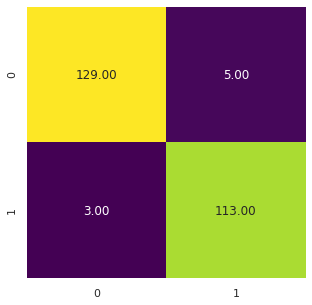

In [599]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(testY,predictions), annot=True, cmap="viridis", cbar=False, fmt=".2f")
plt.show()

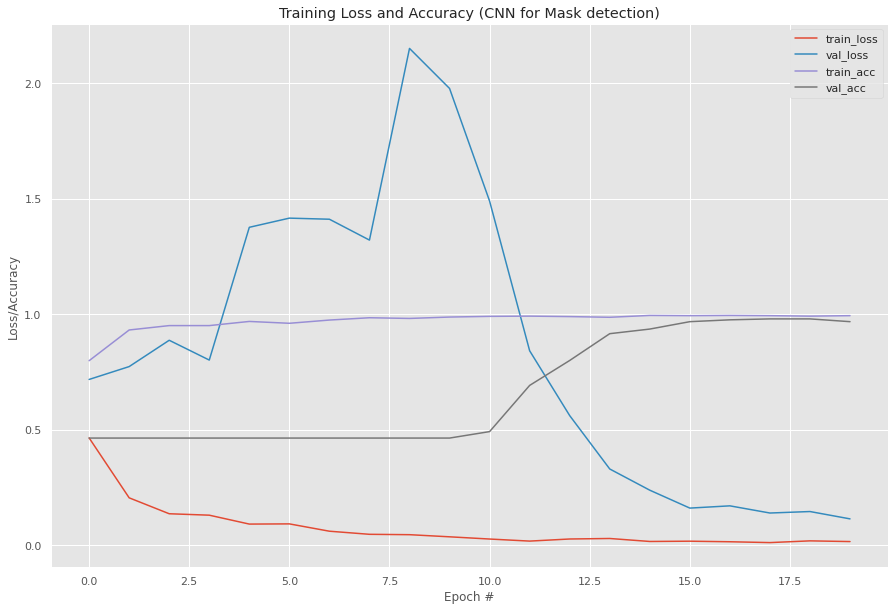

In [600]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (CNN for Mask detection)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [0]:
pred = model.predict(test_images)
pred

In [0]:
pred = pred.round()
pred

In [0]:
#useful indexes - 93,106,9

In [647]:
index = np.random.randint(0,190)
index

77

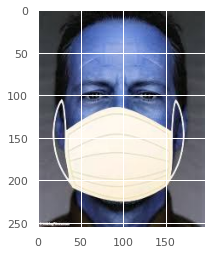

In [648]:
plt.imshow(outputs[index])

In [649]:
val = pred[index]
val

array([0.], dtype=float32)

In [0]:
#0 is mask 
#1 is nomask

In [0]:
net = cv2.dnn.readNetFromCaffe(filepath_prototxt , filepath_model)

In [652]:
outputs[index].shape

(256, 197, 3)

In [0]:
image = outputs[index]
(h,w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(cv2.resize(image,(300,300)), 1.0 ,(300,300) ,(104.0, 177.0, 123.0) )

In [0]:
net.setInput(blob)
detections = net.forward()

In [655]:
detections.shape

(1, 1, 200, 7)

In [0]:
conf = 0.70
no_conf = 1.99

In [0]:
if val == 0:
  result="Mask"
else:
  result="NoMask"

In [0]:
if val == 0:
  color=(0,255,0)
else:
  color=(0,0,255)

In [659]:
result

'Mask'

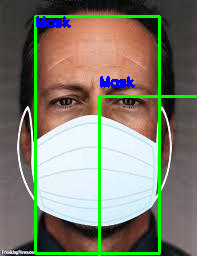

-1

In [660]:

for i in range(0 ,detections.shape[2]):

  confidence = detections[0,0,i,2]

  if ((confidence > conf) and (confidence < no_conf)):
    box = detections[0,0,i,3:7]* np.array([w,h,w,h])
    (startX , startY , endX, endY) = box.astype("int")

    text = str(result)

    y = startY - 10 if startY - 10 > 10 else startY + 10

    cv2.rectangle(image , (startX , startY) , (endX,endY) , color , 2)

    cv2.putText(image , text , (startX , y) , cv2.FONT_HERSHEY_SIMPLEX , 0.45 , (255,0,0), 2 )

cv2_imshow(image)
cv2.waitKey(0)